In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs

Caricamento file pickle

In [2]:
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)

In [3]:
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)

    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)

Medie zonali

In [4]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models_zonmean = {}

In [5]:
#Percorso dei file
name_models_zonmean = '/work/users/guest/sbeltrami/prova/zonal_mean_name_ok_model.txt'
path_models_zonmean = '/work/users/guest/sbeltrami/prova/path_zonal_mean_model.txt'
path_remap_models_zonmean = '/work/users/guest/sbeltrami/prova/path_remap_zonal_mean_model.txt'
path_zonal_model_models_zonmean = '/work/users/guest/sbeltrami/prova/path_zonmean_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models_zonmean, 'r') as file: #nome file
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models_zonmean = file.readlines()
with open(path_models_zonmean, 'r') as file: #percorso dei file .nc
    lines_path_models_zonmean = file.readlines()
with open(path_remap_models_zonmean, 'r') as file: #percorso dei file remap
    lines_path_remap_models_zonmean = file.readlines()
with open(path_zonal_model_models_zonmean, 'r') as file: #percorso dei file remap +zonmean
    lines_path_zonal_model_models_zonmean = file.readlines()

In [6]:
# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap, line_path_zonal_model in zip(lines_name_models_zonmean, lines_path_models_zonmean, lines_path_remap_models_zonmean,lines_path_zonal_model_models_zonmean): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models_zonmean:
        models_zonmean[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models_zonmean[model_name]['zonmean name'] = model_name
    models_zonmean[model_name]['zonmean path'] = line_path.strip()
    models_zonmean[model_name]['zonmean path remap'] = line_path_remap.strip()
    models_zonmean[model_name]['zonmean path remap zonal mean'] = line_path_zonal_model.strip()

In [7]:
model_name = 'ACCESS-CM2'
models_zonmean[model_name]['zonmean path remap']

'/work/users/guest/sbeltrami/zonal_mean/ACCESS-CM2_remapcon.nc'

In [8]:
#REMAP
for name in models_zonmean.keys():
    path_remap = models_zonmean[name]['zonmean path remap'] #remap
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_zonmean[name]['zonmean remap dataset'] = xr.open_dataset(path_remap)        
        models_zonmean[name]['zonmean remap dataset'] = models_zonmean[name]['zonmean remap dataset'].assign_coords({"plev" : models_zonmean[name]['zonmean remap dataset'].plev.round()}) # Per essere sicuri che i plev siano gli stessi
        models_zonmean[name]['zonmean remap dataset'] = models_zonmean[name]['zonmean remap dataset'].sel(lat=slice(20,80),plev=slice(100000.,20000.)) #taglio al di sopra di 200 hPa
        dataset_remap = models_zonmean[name]['zonmean remap dataset']
        #Seleziono il periodo 1982-2014
        models_zonmean[name]['zonmean remap period 1982 2014'] = dataset_remap['ua'].sel(time=slice("1982-01", "2014-12"))
        dataset_period = models_zonmean[name]['zonmean remap period 1982 2014']
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

In [9]:
#REMAP + ZONMEAN
for name in models_zonmean.keys():
    path_remap = models_zonmean[name]['zonmean path remap zonal mean'] #remap + zonmean
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_zonmean[name]['zonmean dataset'] = xr.open_dataset(path_remap)        
        models_zonmean[name]['zonmean dataset'] = models_zonmean[name]['zonmean dataset'].assign_coords({"plev" : models_zonmean[name]['zonmean dataset'].plev.round()}) # Per essere sicuri che i plev siano gli stessi
        models_zonmean[name]['zonmean dataset'] = models_zonmean[name]['zonmean dataset'].sel(lat=slice(20,80),plev=slice(100000.,20000.)) #taglio al di sopra di 200 hPa
        dataset = models_zonmean[name]['zonmean dataset']
        #Seleziono il periodo 1982-2014
        models_zonmean[name]['zonmean period 1982 2014'] = dataset['ua'].sel(time=slice("1982-01", "2014-12"))
        dataset_period = models_zonmean[name]['zonmean period 1982 2014']
        #peso il dataset
        models_zonmean[name]['zonmean dataset weighted'] = compute_dataset_weighted(dataset_period)
        #faccio la media nel tempo del dataset nel periodo 1982 - 2014
        models_zonmean[name]['zonmean mean 1982 - 2014'] = models_zonmean[name]['zonmean dataset weighted'].mean(dim='time')
        print(models_zonmean[name]['zonmean name']) 
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0


EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorESM2-LM
NorESM2-MM
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


ERA5

In [10]:
#ERA5 box Nord Atlantico
dataset_ERA_zonmean=xr.open_dataset('/work/users/guest/sbeltrami/prova/ERA5_zonal_mean.nc')
dataset_ERA_zonmean = dataset_ERA_zonmean['var131'].sel(time=slice("1982-01", "2014-12"),lat=slice(20,80),plev=slice(100000.,20000.)) #seleziono il periodo 1982 - 2014
#dataset pesato
dataset_ERA_weighted_zonmean = compute_dataset_weighted(dataset_ERA_zonmean)

dict_keys([1, 2, 3, 4])


Text(0.5, 1.0, 'ERA5 DJF')

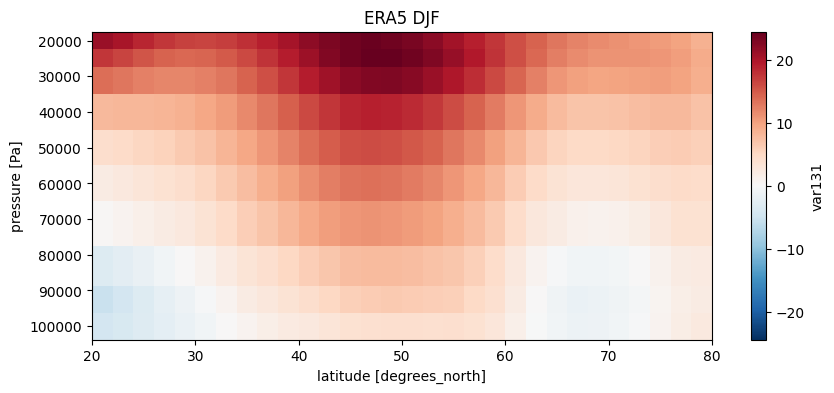

In [11]:
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
era_seas_mean = {}
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    era_seas_mean[i+1] = compute_mean_resample_mar(dataset_ERA_zonmean,"1982","2014",i)
print(era_seas_mean.keys())
#plot DJF
fig, ax = plt.subplots(figsize=(10,4))
era_seas_mean[4].plot(ax=ax)
ax.invert_yaxis()
ax.set_title('ERA5 DJF')


Bias zonal mean

In [12]:
for name in models_zonmean.keys():
    box = models_zonmean[name]['zonmean dataset']
    models_zonmean[name]['zonmean seasonal mean'] = None  # Inizializzo con un valore vuoto
    
    # Media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # Ciclo su tutte le stagioni
        # Calcolo la media temporale per ogni stagione dei modelli

        if (i+1) == 4 : # DJF
            models_zonmean[name]['zonmean seasonal mean DJF'] = compute_mean_resample_mar(box["ua"],"1982","2014",i)
            model_seas_mean = models_zonmean[name]['zonmean seasonal mean DJF']
            model_seas_mean = model_seas_mean.assign_coords({"plev" : model_seas_mean.plev.round()}) # Per essere sicuri che i plev siano gli stessi
            models_zonmean[name]['zonmean bias DJF'] = model_seas_mean - era_seas_mean[i+1]

Plot del bias di tutti i modelli (relativo a ERA5, periodo 1982-2014 DJF)

In [13]:
#Creo una lista con il nome dei modelli
models_list_zonmean = list(models_zonmean.keys())

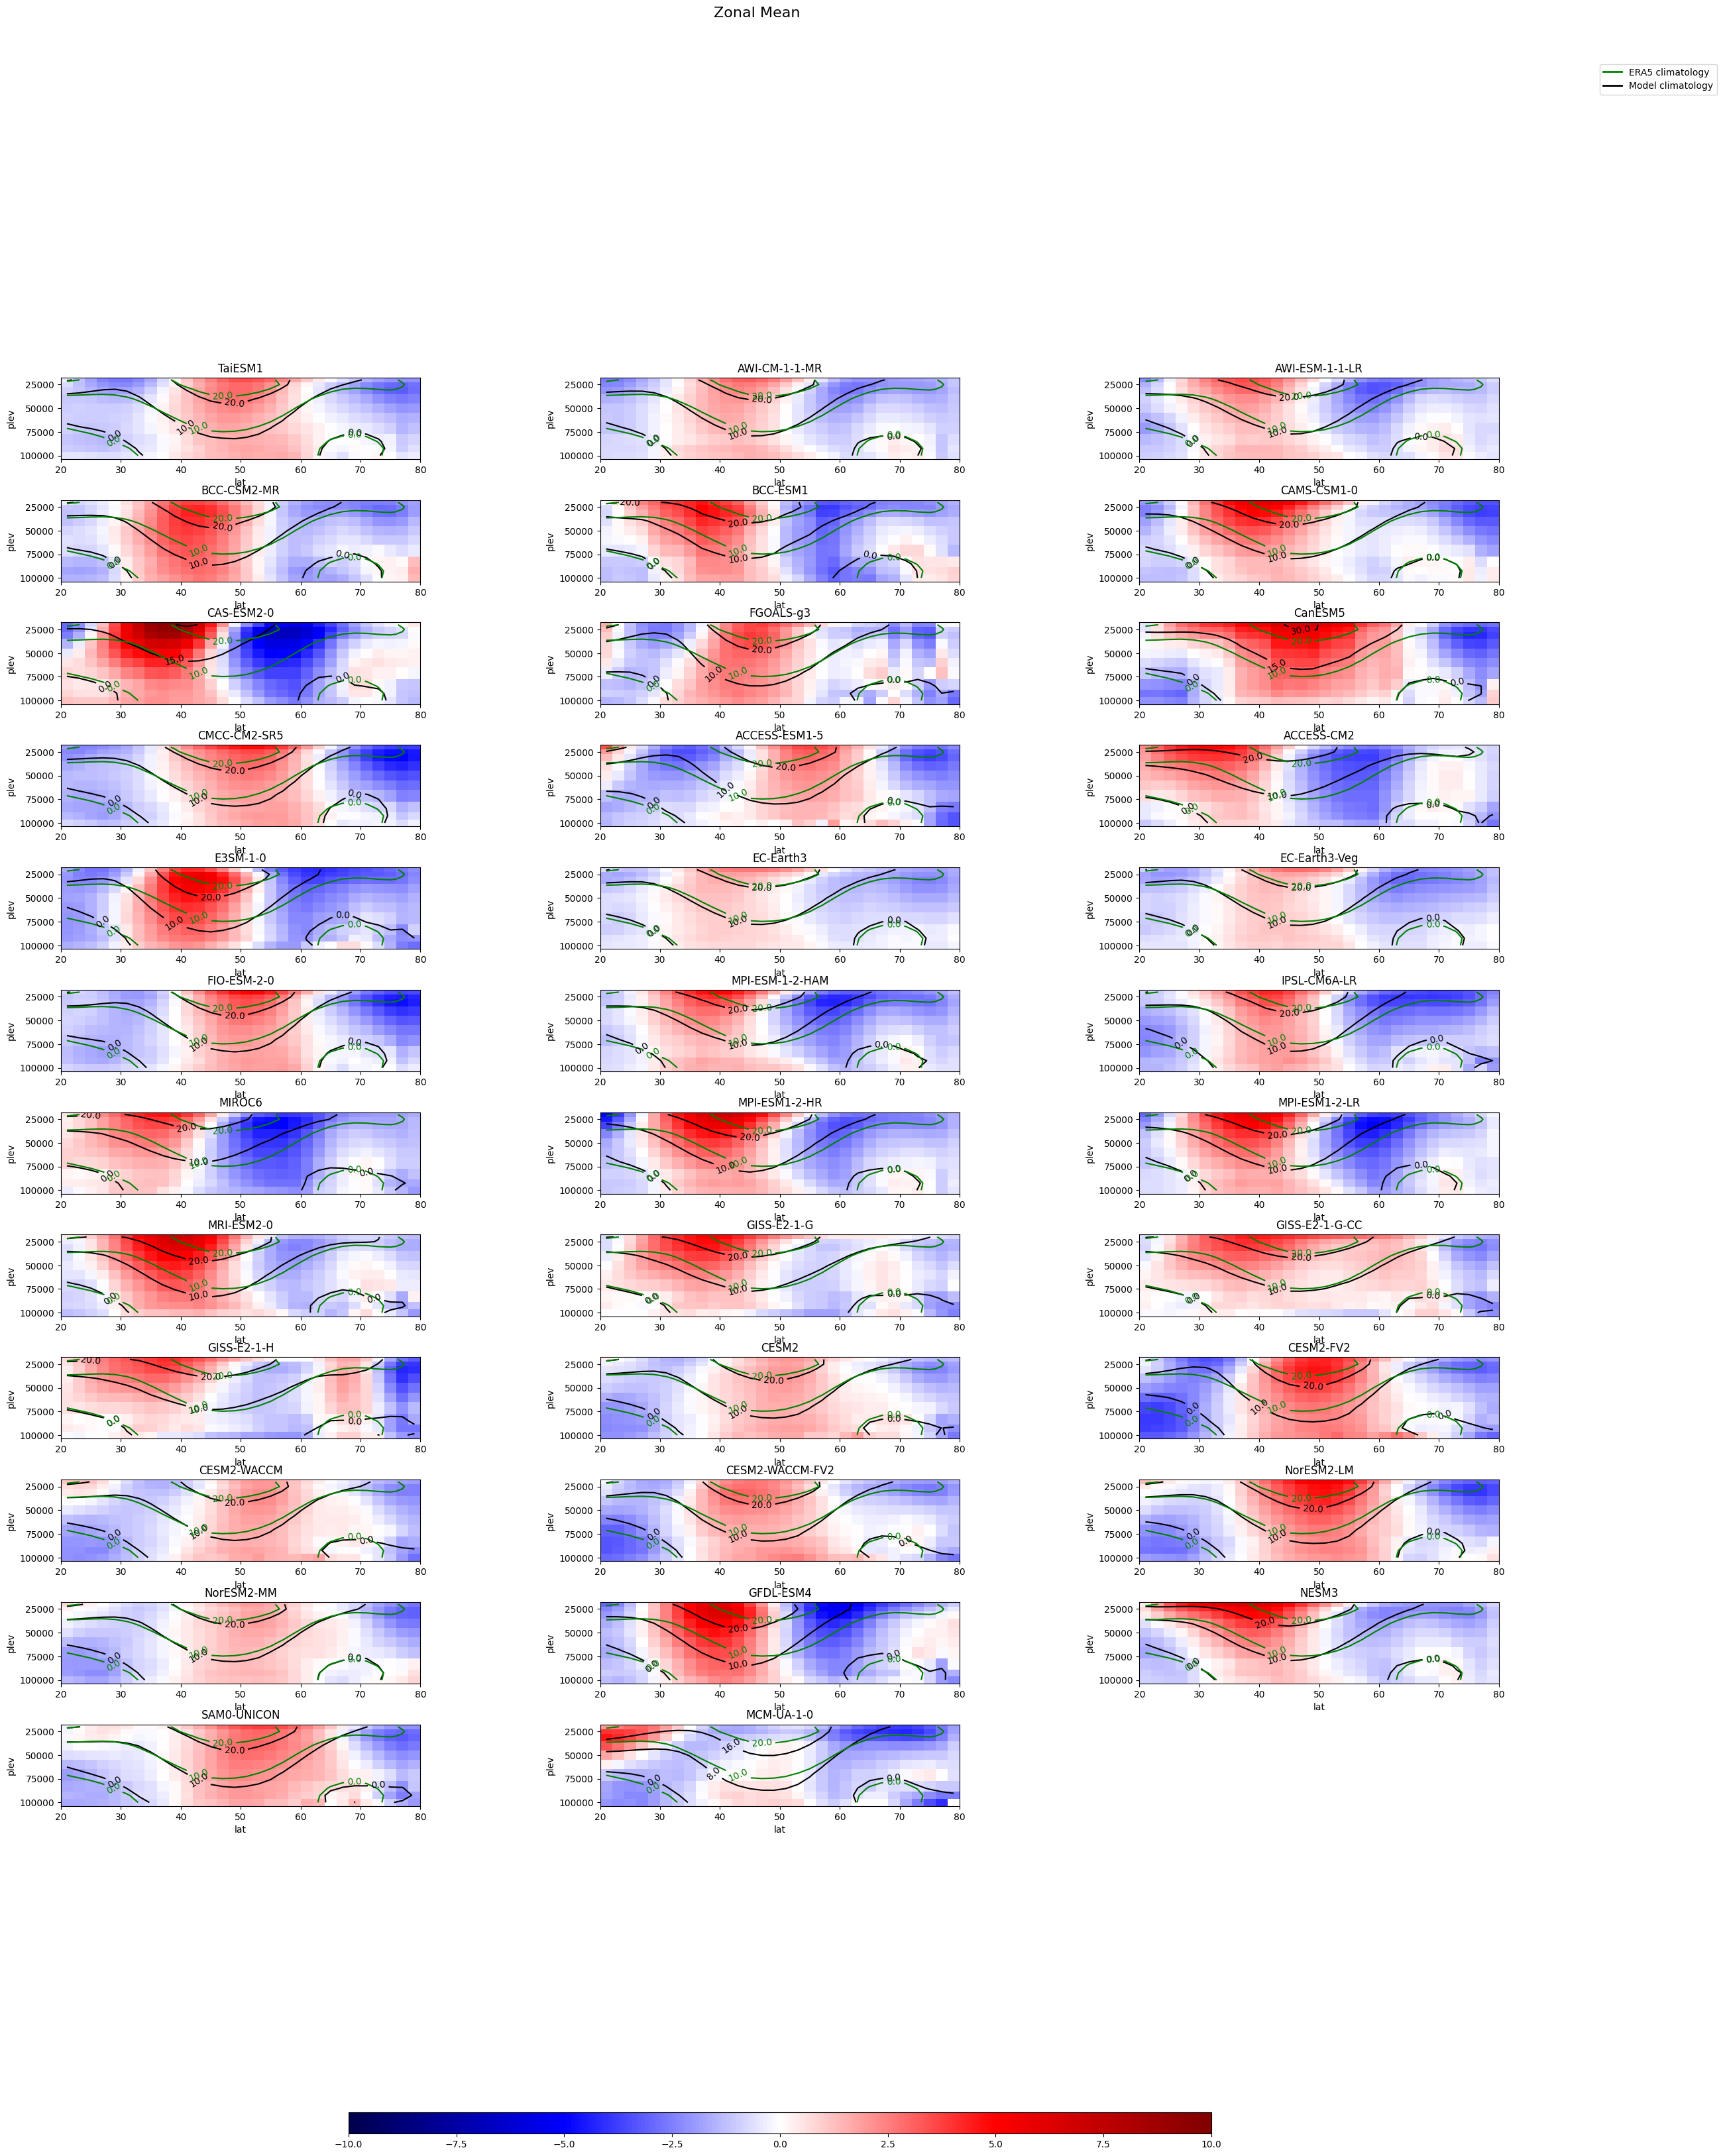

In [14]:
plot_zonmean((int(len(models_zonmean)/3)+1),3,(28,40),models_list_zonmean,models_zonmean,era_seas_mean,-10,10,'Zonal Mean','zonal_mean.pdf')

Plot delle medie zonali nei 5 cluster

Cluster 0

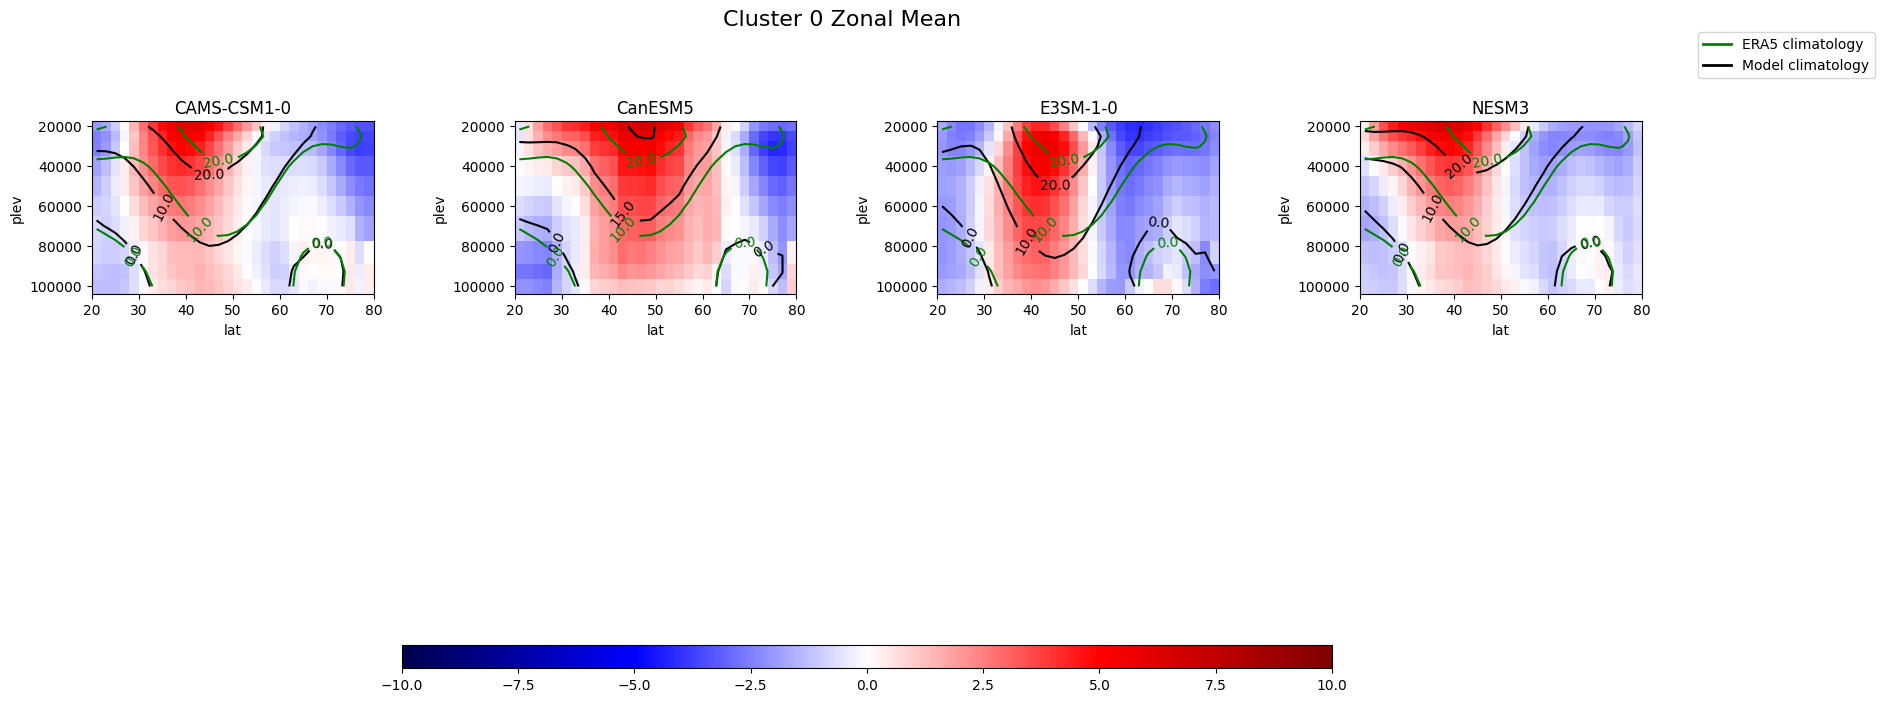

In [15]:
plot_zonmean(int(len(list_cluster0)/4)+1,4,(20,8),list_cluster0,models_zonmean,era_seas_mean,-10,10,'Cluster 0 Zonal Mean','zonmean_cluster0.pdf')

Cluster 1

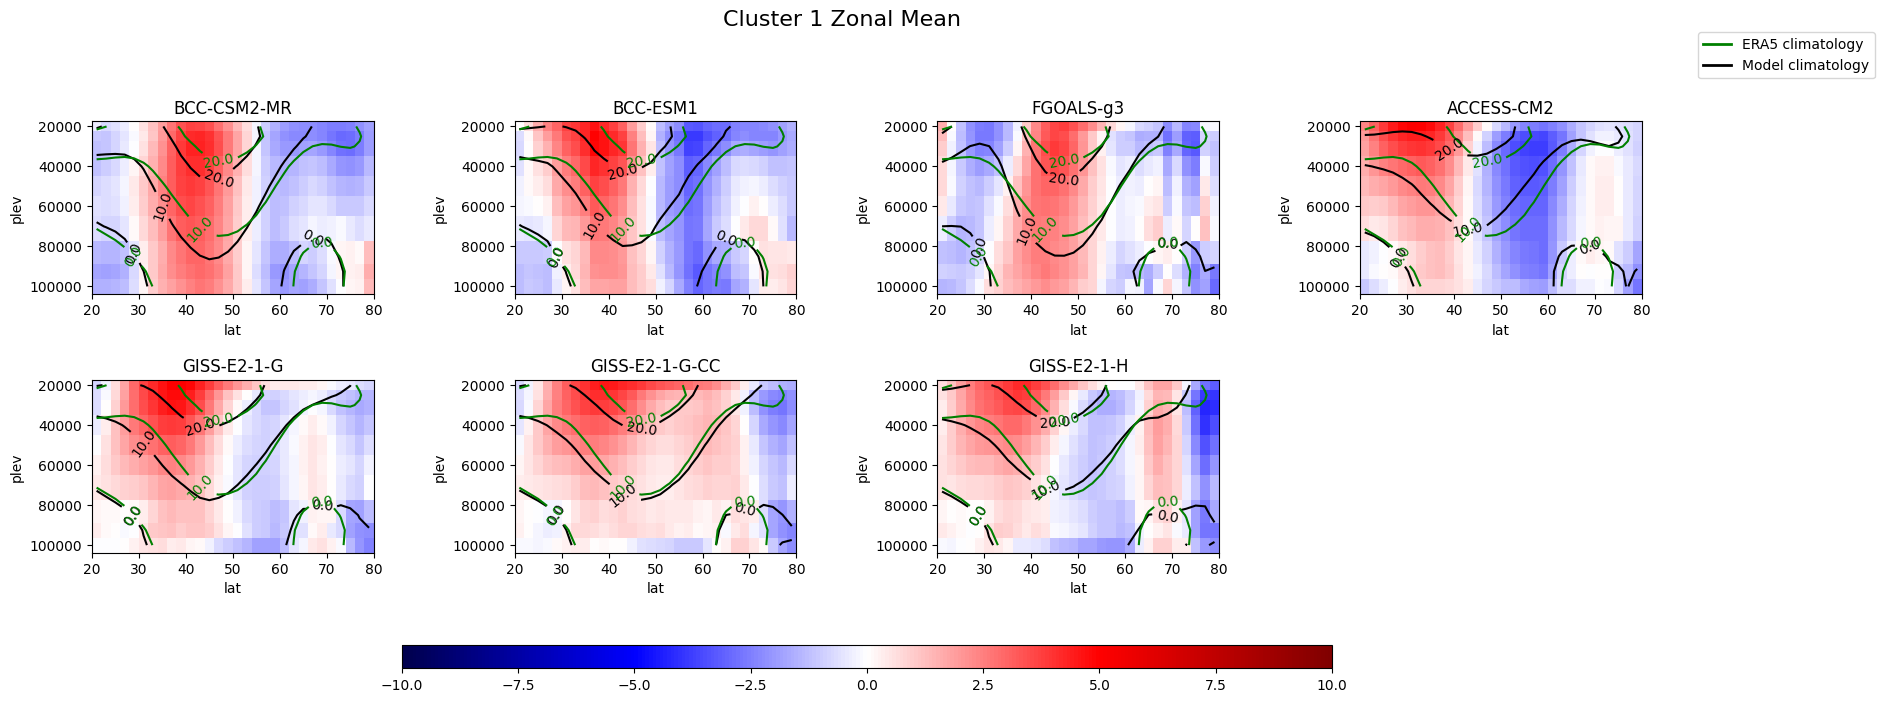

In [16]:
plot_zonmean(int(len(list_cluster1)/4)+1,4,(20,8),list_cluster1,models_zonmean,era_seas_mean,-10,10,'Cluster 1 Zonal Mean','zonmean_cluster1.pdf')

Cluster 2

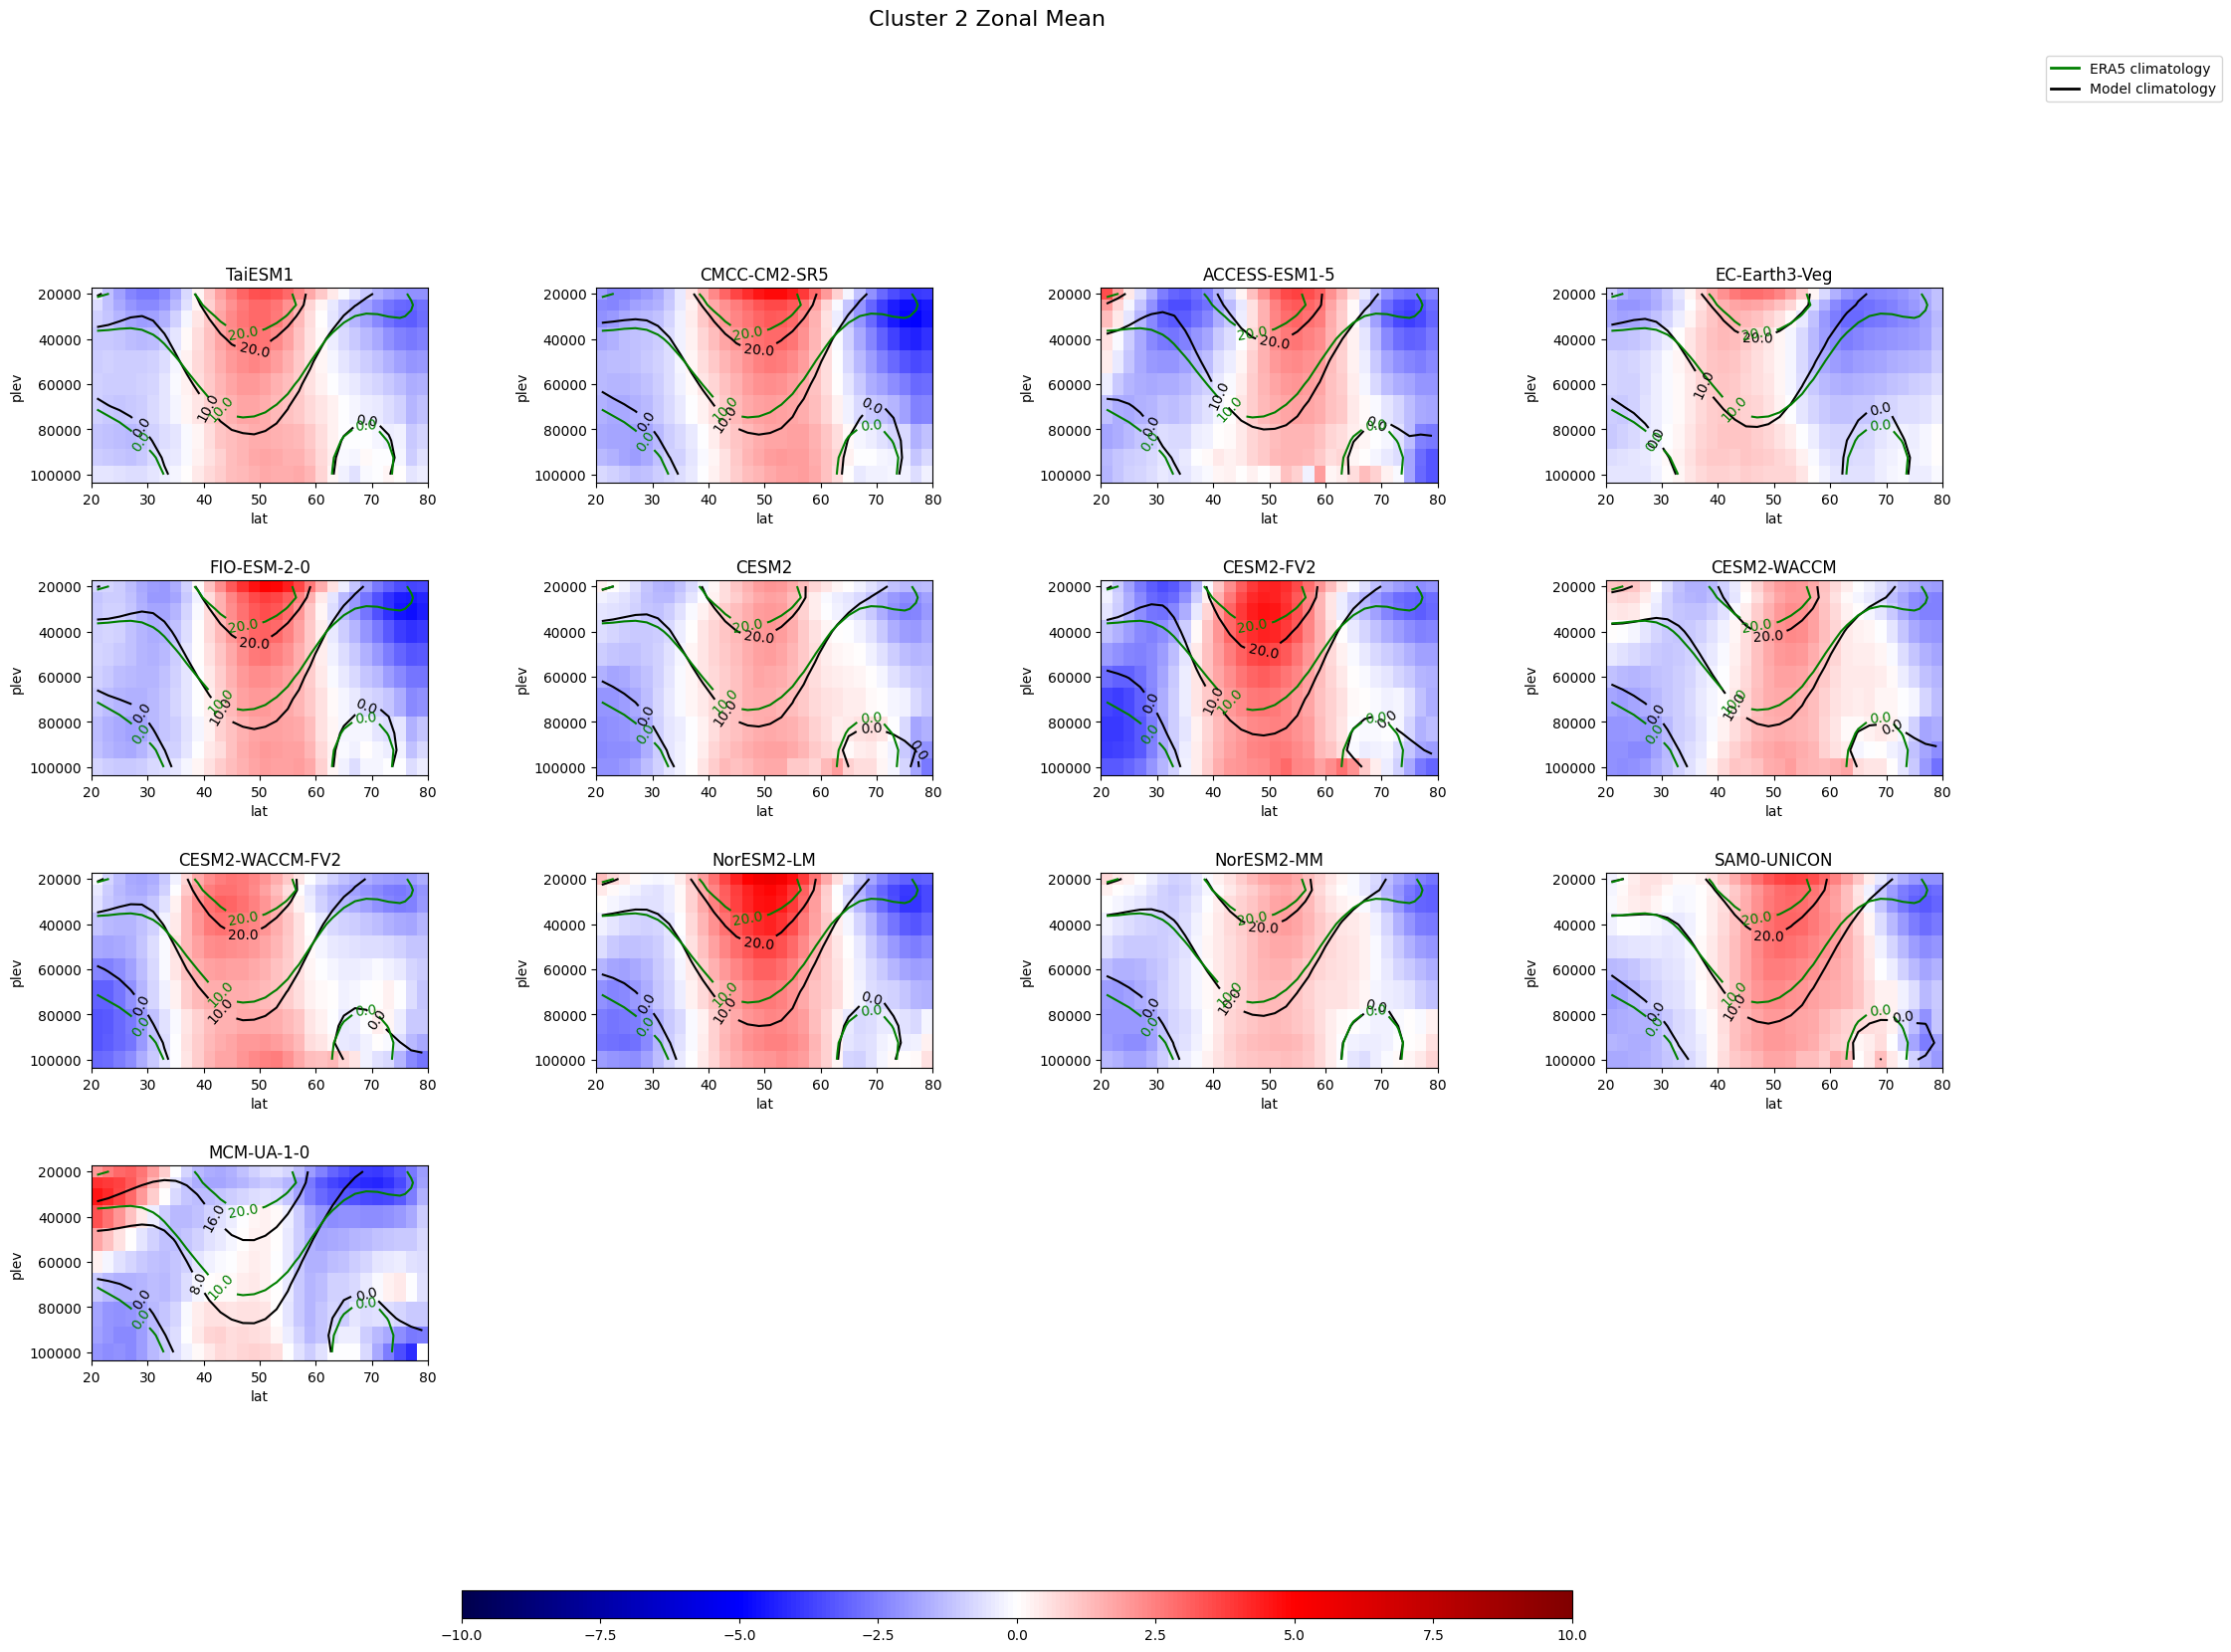

In [17]:
plot_zonmean(int(len(list_cluster2)/4)+1,4,(24,20),list_cluster2,models_zonmean,era_seas_mean,-10,10,'Cluster 2 Zonal Mean','zonmean_cluster2.pdf')

Cluster 3

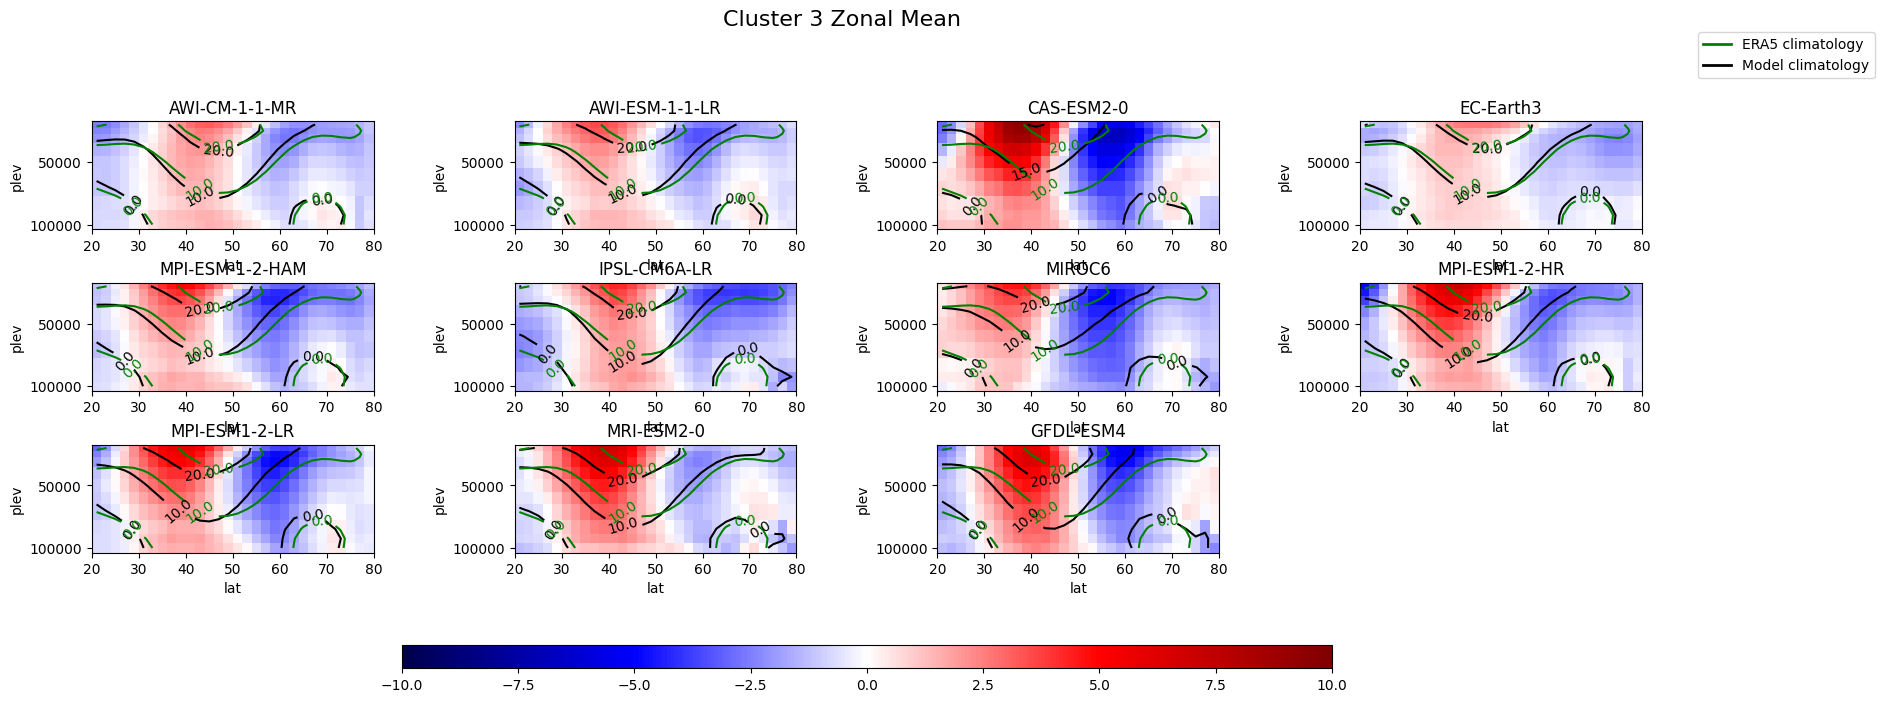

In [18]:
plot_zonmean(int(len(list_cluster3)/4)+1,4,(20,8),list_cluster3,models_zonmean,era_seas_mean,-10,10,'Cluster 3 Zonal Mean','zonmean_cluster3.pdf')

Plot dei cluster medi

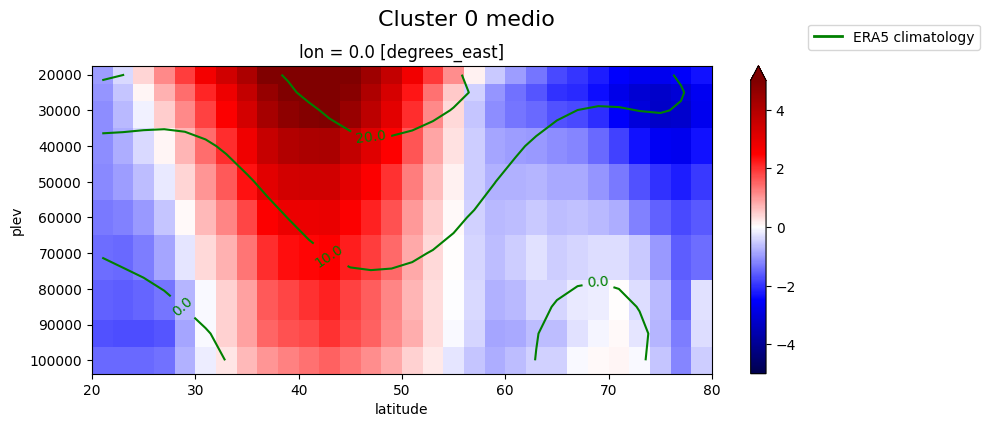

In [19]:
plot_mean_cluster_zonmean(len(list_cluster0),list_cluster0,models_zonmean,era_seas_mean,'Cluster 0 medio','zonmean_cluster0_mean.pdf',-5,5,(10,4))

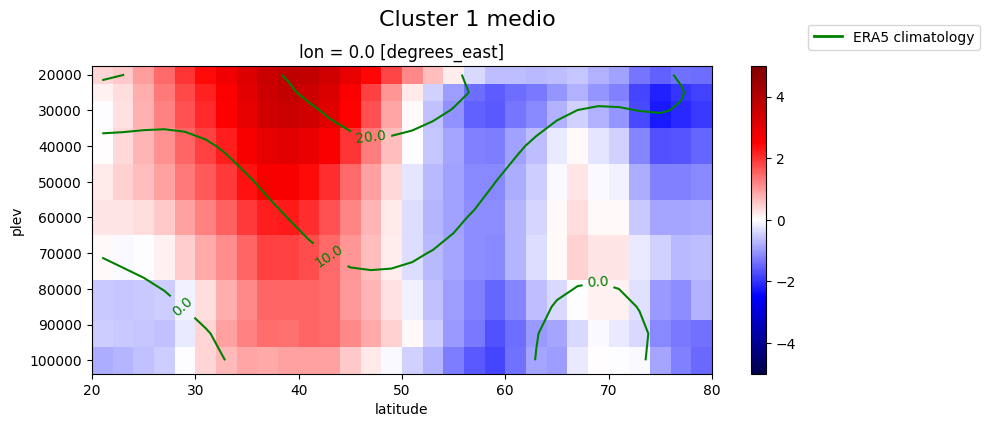

In [20]:
plot_mean_cluster_zonmean(len(list_cluster1),list_cluster1,models_zonmean,era_seas_mean,'Cluster 1 medio','zonmean_cluster1_mean.pdf',-5,5,(10,4))

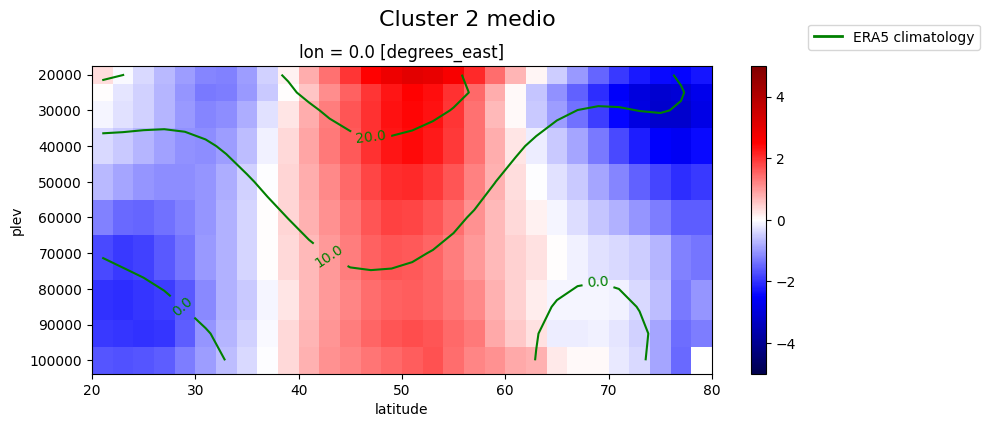

In [21]:
plot_mean_cluster_zonmean(len(list_cluster2),list_cluster2,models_zonmean,era_seas_mean,'Cluster 2 medio','zonmean_cluster2_mean.pdf',-5,5,(10,4))

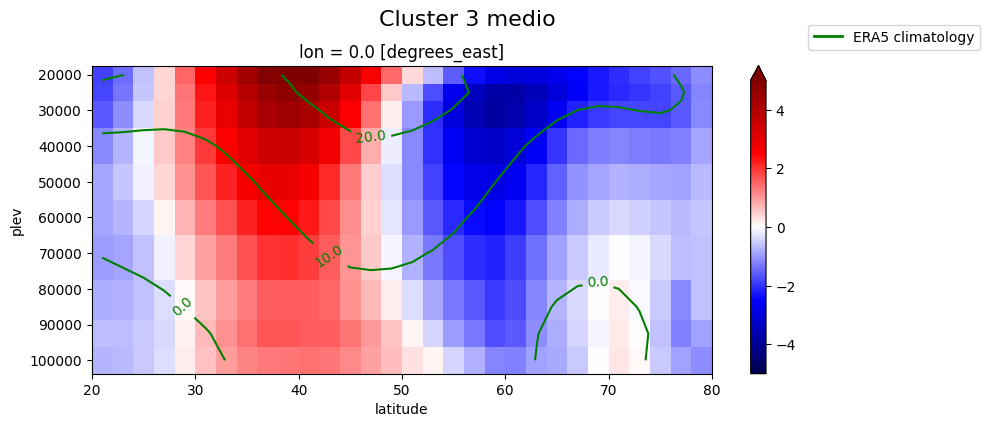

In [22]:
plot_mean_cluster_zonmean(len(list_cluster3),list_cluster3,models_zonmean,era_seas_mean,'Cluster 3 medio','zonmean_cluster3_mean.pdf',-5,5,(10,4))

Salvataggio in file pickle

In [23]:
# Salvataggio di models_zonmean
with open('models_zonmean.pkl', 'wb') as file:
    dill.dump(models_zonmean, file)
    dill.dump(era_seas_mean,file)
# Salvataggio liste e immagini pdf in un file Pickle
with open('modelli_zonmean.pickle', 'wb') as f: #'wb' = write binary
    pickle.dump('zonmean_cluster0.pdf', f) #salvataggio immagini modelli per ogni cluster
    pickle.dump('zonmean_cluster1.pdf', f)
    pickle.dump('zonmean_cluster2.pdf', f)
    pickle.dump('zonmean_cluster3.pdf', f) 
    pickle.dump('zonmean_cluster0_mean.pdf', f) #salvataggio immagini cluster medio
    pickle.dump('zonmean_cluster1_mean.pdf', f)    
    pickle.dump('zonmean_cluster2_mean.pdf', f)    
    pickle.dump('zonmean_cluster3_mean.pdf', f) 